# Generative Adversarial Network (GAN) Project

### Table of Contents
- [Description](#Description)
- [EDA](#Exploratory-Data-Analysis-Procedure)
- [GAN Model](#GAN-Model)
- [Results and Analysis](#Results-and-Analysis)
- [Hypertuning](#Hypertuning)
- [Conclusion](#Conclusion)
- [Citation](#Citation)

Github: https://github.com/GHeart01/GenerativeAdversarialNetwork

### Description

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

From the Kaggle description:
- Monet Training Set: ~300 authentic Monet paintings for style reference
- Photo Training Set: ~7,000 landscape photographs to be transformed
- Photo Test Set: Images that need to be converted to Monet style for submission
- Image Format: Both TFRecord format (recommended) and JPEG images are provided
- Image Dimensions: Typically 256x256 or 512x512 pixels
- Color Channels: RGB (3 channels)

#### The Challenge:
The challenge involves training a Generative Adversarial Network (GAN) to perform style transfer, converting photographic images into Monet-style paintings. The generator is trained using a discriminator, with the two models working against each other - the generator trying to trick the discriminator, and the discriminator trying to accurately classify real vs. generated images.

### Exploratory Data Analysis

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

2025-07-28 07:32:01.788770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753687921.997045      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753687922.057292      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Lets take a quick look at the data

  📁 monet_jpg/ (contains 300 items)
  📁 photo_tfrec/ (contains 20 items)
  📁 photo_jpg/ (contains 7038 items)
  📁 monet_tfrec/ (contains 5 items)
Loading from TFRecord files...
  Found 5 Monet TFRecord files
  Found 20 Photo TFRecord files


I0000 00:00:1753687936.435829      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



SAMPLE IMAGES


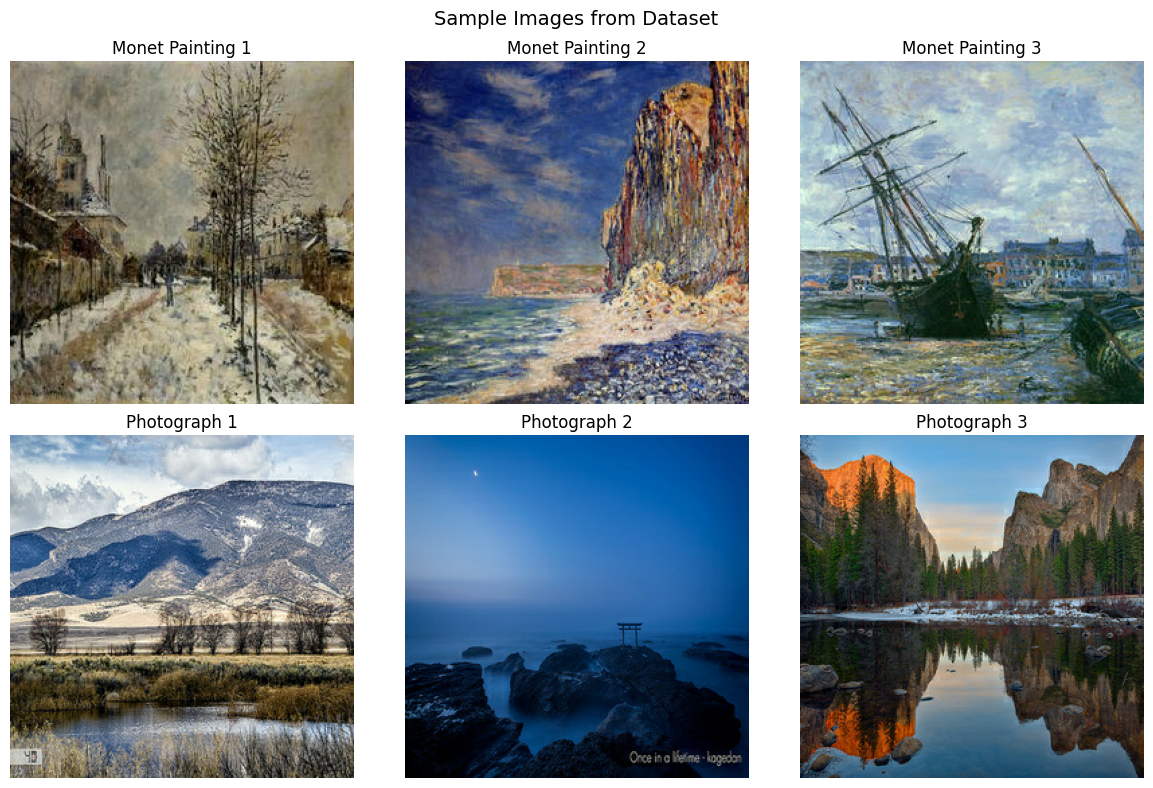


DATASET INFORMATION
Dataset Sizes (partial count):
  • Monet paintings: 300 (counted first 500)
  • Photographs: 500 (counted first 500)
  • Total images counted: 800

Image Properties:
  • Dimensions: 256 x 256 pixels
  • Channels: 3 (RGB)
  • Data type: <dtype: 'float32'>
  • Value range: [-1.0, 1.0]
  • File format: TFRecord or JPEG

Data Structure:
  • Input: Photographs (to be transformed)
  • Target: Monet-style paintings (reference style)
  • Task: Unpaired image-to-image translation
  • Architecture: CycleGAN (no paired training data needed)


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

def load_image_from_path(image_path):
    """Load and preprocess a single image from file path"""
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    
    # Normalize to [-1, 1] range
    image = (image / 127.5) - 1.0
    
    # Resize to standard size (256x256 is common for GANs)
    image = tf.image.resize(image, [256, 256])
    
    return image

def decode_tfrecord_image(record):
    """Decode TFRecord image data"""
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(record, feature_description)
    
    # Decode the image
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32)
    
    # Normalize to [-1, 1] range
    image = (image / 127.5) - 1.0
    
    # Resize to standard size
    image = tf.image.resize(image, [256, 256])
    
    return image

def load_competition_datasets():
    """Load the Monet and photo datasets from either TFRecord or JPG directories"""
    
    # Check what files actually exist in the dataset
    base_path = '/kaggle/input/gan-getting-started'
    
    if os.path.exists(base_path):
        for item in os.listdir(base_path):
            item_path = os.path.join(base_path, item)
            if os.path.isdir(item_path):
                print(f"  📁 {item}/ (contains {len(os.listdir(item_path))} items)")
    else:
        print(f"Base path {base_path} does not exist!")
        return None, None
    
    try:
        # Check for TFRecord files first
        tfrecord_monet_files = glob.glob(f'{base_path}/monet_tfrec/*.tfrec')
        tfrecord_photo_files = glob.glob(f'{base_path}/photo_tfrec/*.tfrec')
        
        if tfrecord_monet_files and tfrecord_photo_files:
            print(f"Loading from TFRecord files...")
            print(f"  Found {len(tfrecord_monet_files)} Monet TFRecord files")
            print(f"  Found {len(tfrecord_photo_files)} Photo TFRecord files")
            
            monet_ds = tf.data.TFRecordDataset(tfrecord_monet_files)
            photo_ds = tf.data.TFRecordDataset(tfrecord_photo_files)
            
            monet_ds = monet_ds.map(decode_tfrecord_image, num_parallel_calls=tf.data.AUTOTUNE)
            photo_ds = photo_ds.map(decode_tfrecord_image, num_parallel_calls=tf.data.AUTOTUNE)
            
        else:
            # Try loading from JPG directories
            monet_jpg_files = glob.glob(f'{base_path}/monet_jpg/*.jpg')
            photo_jpg_files = glob.glob(f'{base_path}/photo_jpg/*.jpg')
            
            if monet_jpg_files and photo_jpg_files:
                print(f"Loading from JPG directories...")
                print(f"  Found {len(monet_jpg_files)} Monet JPG files")
                print(f"  Found {len(photo_jpg_files)} Photo JPG files")
                
                monet_ds = tf.data.Dataset.from_tensor_slices(monet_jpg_files)
                photo_ds = tf.data.Dataset.from_tensor_slices(photo_jpg_files)
                
                monet_ds = monet_ds.map(load_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
                photo_ds = photo_ds.map(load_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
            else:
                print("❌ No TFRecord or JPG files found!")
                return None, None
           
        return monet_ds, photo_ds
        
    except Exception as e:
        print(f"❌ Error loading datasets: {e}")
        return None, None

def simple_eda():
    """Simple EDA showing sample images and basic dataset information"""
    
    # Load datasets
    monet_ds, photo_ds = load_competition_datasets()
    

    
    
    # 1. DISPLAY SAMPLE IMAGES
    print("\n" + "="*50)
    print("SAMPLE IMAGES")
    print("="*50)
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle('Sample Images from Dataset', fontsize=14)
    
    # Display 3 Monet samples
    monet_samples = list(monet_ds.take(3))
    for i in range(3):
        img = (monet_samples[i] + 1) / 2.0  # Denormalize to [0,1]
        axes[0, i].imshow(img.numpy())
        axes[0, i].set_title(f'Monet Painting {i+1}')
        axes[0, i].axis('off')
    
    # Display 3 photo samples
    photo_samples = list(photo_ds.take(3))
    for i in range(3):
        img = (photo_samples[i] + 1) / 2.0  # Denormalize to [0,1]
        axes[1, i].imshow(img.numpy())
        axes[1, i].set_title(f'Photograph {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 2. DATASET INFORMATION
    print("\n" + "="*50)
    print("DATASET INFORMATION")
    print("="*50)
    
    # Count samples - use smaller numbers for efficiency
    monet_count = sum(1 for _ in monet_ds.take(500))
    photo_count = sum(1 for _ in photo_ds.take(500))
    
    # Get sample image properties
    sample_monet = next(iter(monet_ds))
    
    print(f"Dataset Sizes (partial count):")
    print(f"  • Monet paintings: {monet_count} (counted first 500)")
    print(f"  • Photographs: {photo_count} (counted first 500)")
    print(f"  • Total images counted: {monet_count + photo_count}")
    
    print(f"\nImage Properties:")
    print(f"  • Dimensions: {sample_monet.shape[0]} x {sample_monet.shape[1]} pixels")
    print(f"  • Channels: {sample_monet.shape[2]} (RGB)")
    print(f"  • Data type: {sample_monet.dtype}")
    print(f"  • Value range: [{tf.reduce_min(sample_monet):.1f}, {tf.reduce_max(sample_monet):.1f}]")
    print(f"  • File format: TFRecord or JPEG")
    
    print(f"\nData Structure:")
    print(f"  • Input: Photographs (to be transformed)")
    print(f"  • Target: Monet-style paintings (reference style)")
    print(f"  • Task: Unpaired image-to-image translation")
    print(f"  • Architecture: CycleGAN (no paired training data needed)")
    
    return monet_ds, photo_ds

# Run simple EDA
if __name__ == "__main__":
    monet_ds, photo_ds = simple_eda()

#### Histograms

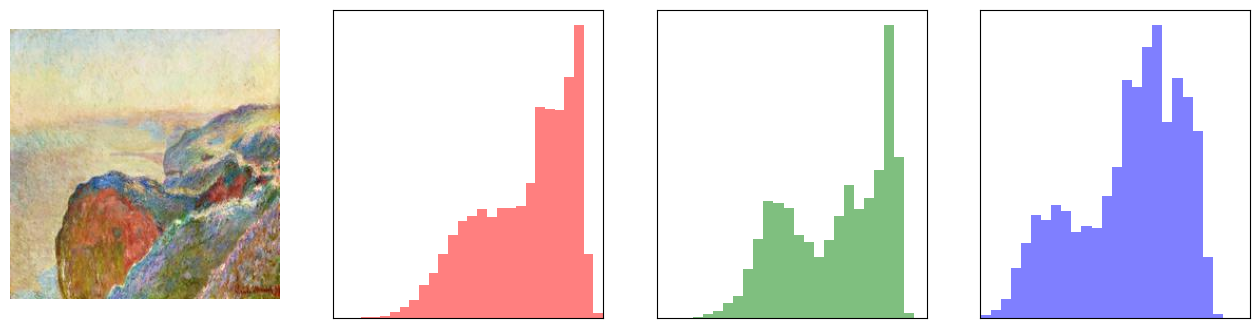

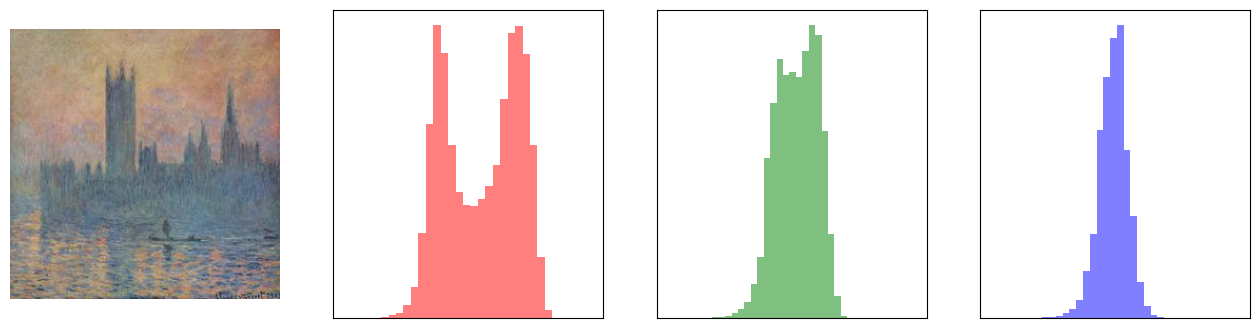

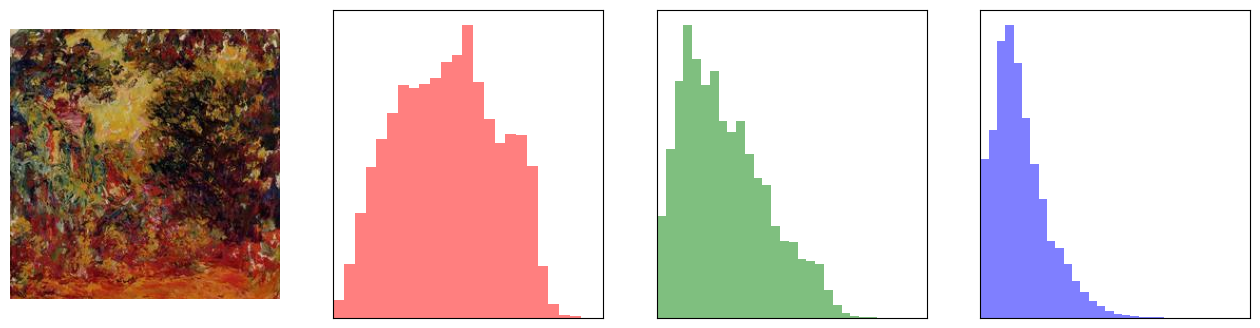

In [3]:
import cv2

def color_hist_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis("off")
    
    colors = ["red", "green", "blue"]
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=25,
            alpha=0.5,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
    
    
    plt.show()

img_path = '/kaggle/input/gan-getting-started/monet_jpg/000c1e3bff.jpg'
color_hist_visualization(img_path)

img_path = '/kaggle/input/gan-getting-started/monet_jpg/05144e306f.jpg'
color_hist_visualization(img_path)

img_path = '/kaggle/input/gan-getting-started/monet_jpg/16dabe418c.jpg'
color_hist_visualization(img_path)

### GAN Model

In [4]:
import os
import math
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from   tensorflow import keras
from   tensorflow.keras import layers
# import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K
import os, random, json, PIL, shutil, re, glob
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback
from kaggle_datasets import KaggleDatasets

### configure TPU

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
print(f'REPLICAS: {REPLICAS}')

REPLICAS: 1


#### Load in Model

In [6]:
BASE_PATH = '/kaggle/input/gan-getting-started/'
MONET_PATH = os.path.join(BASE_PATH, 'monet_jpg')
PHOTO_PATH = os.path.join(BASE_PATH, 'photo_jpg')

In [7]:
def show_folder_info(path):
    d_image_sizes = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1
        
    for size, count in d_image_sizes.items():
        print(f'shape: {size}\tcount: {count}')


print('Monet images:')
show_folder_info(MONET_PATH)

print('Photo images:')
show_folder_info(PHOTO_PATH)

Monet images:
shape: (256, 256, 3)	count: 300
Photo images:
shape: (256, 256, 3)	count: 7038


In [8]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [9]:
# Get the Google Cloud Storage path URI (GCS path) for Kaggle Datasets
GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')

GCS_PATH

'gs://kds-391cf571c687c94d5e54e76604fa78e14bb3663266e3abbe905a3691'

In [10]:
# Obtain two lists of files that match the given patterns specified in str()
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print('Number of Monet TFRecord Files:', len(MONET_FILENAMES))
print('Number of Photo TFRecord Files:', len(PHOTO_FILENAMES))

Number of Monet TFRecord Files: 5
Number of Photo TFRecord Files: 20


In [11]:
BUFFER_SIZE = 1000
BATCH_SIZE =  4
EPOCHS_NUM = 30
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [12]:
def decode_image(image):
    # Decode a JPEG-encoded image to a uint8 tensor.
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Normalize the image to the range of the tanh activation function [-1, 1] for 
    # inputs to the generator and discriminator in GAN model 
    # (i.e. the pixel values are divided by (255/2) to form a value of in a range of [0, 2] and then subtract by 1
    # to result into a range of [-1, 1])
    image = (tf.cast(image, tf.float32) / 127.5) - 1        
    
    # Reshape the tensor using (256, 256, 3) where 3 is number of channels: Red, Green, and Blue 
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 3])             
    return image

def read_tfrecord(example):
    # Define TFRecord format 
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image":      tf.io.FixedLenFeature([], tf.string),
        "target":     tf.io.FixedLenFeature([], tf.string)
    }
    # Parse a single example
    example = tf.io.parse_single_example(example, tfrecord_format)  
    # Decode a JPEG image to a uint8 tensor by calling decode_image()
    image = decode_image(example['image'])    
    
    return image # Return an image tensor

In [13]:
def data_augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Apply jitter
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, 3])
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])
    
    # Random rotation
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
    
    # Random mirroring
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
    
    return image

In [14]:
# Set it to tf.data.experimental.AUTOTUNE which will prompt 
# the tf.data runtime to tune the value dynamically at runtime.
AUTOTUNE = tf.data.experimental.AUTOTUNE  

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    # map a dataset with a mapping function read_tfrecord and 
    # Number of parallel calls is set to AUTOTUNE constant previously defined
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [15]:
BATCHSIZE = 1
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(BATCHSIZE, drop_remainder=True)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(BATCHSIZE, drop_remainder=True)

In [16]:
AUTO = tf.data.AUTOTUNE


def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
        
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

In [17]:
full_dataset = get_gan_dataset(MONET_FILENAMES,
                               PHOTO_FILENAMES, augment=data_augment, repeat=True, 
                               shuffle=True, batch_size=BATCH_SIZE)

In [18]:
example_monet , example_photo = next(iter(full_dataset))

In [19]:
def view_image(ds, nrows=1, ncols=5):
    ds_iter = iter(ds)
    # image = next(iter(ds)) # extract 1 from the dataset
    # image = image.numpy()  # convert the image tensor to NumPy ndarrays.

    fig = plt.figure(figsize=(25, nrows * 5.05 )) # figsize with Width, Height
    
    # loop thru all the images (number of rows * number of columns)
    for i in range(ncols * nrows):
        image = next(ds_iter)
        image = image.numpy()
        ax = fig.add_subplot(nrows, ncols, i+1, xticks=[], yticks=[])
        ax.imshow(image[0] * 0.5 + .5) # rescale the data in [0, 1] for display

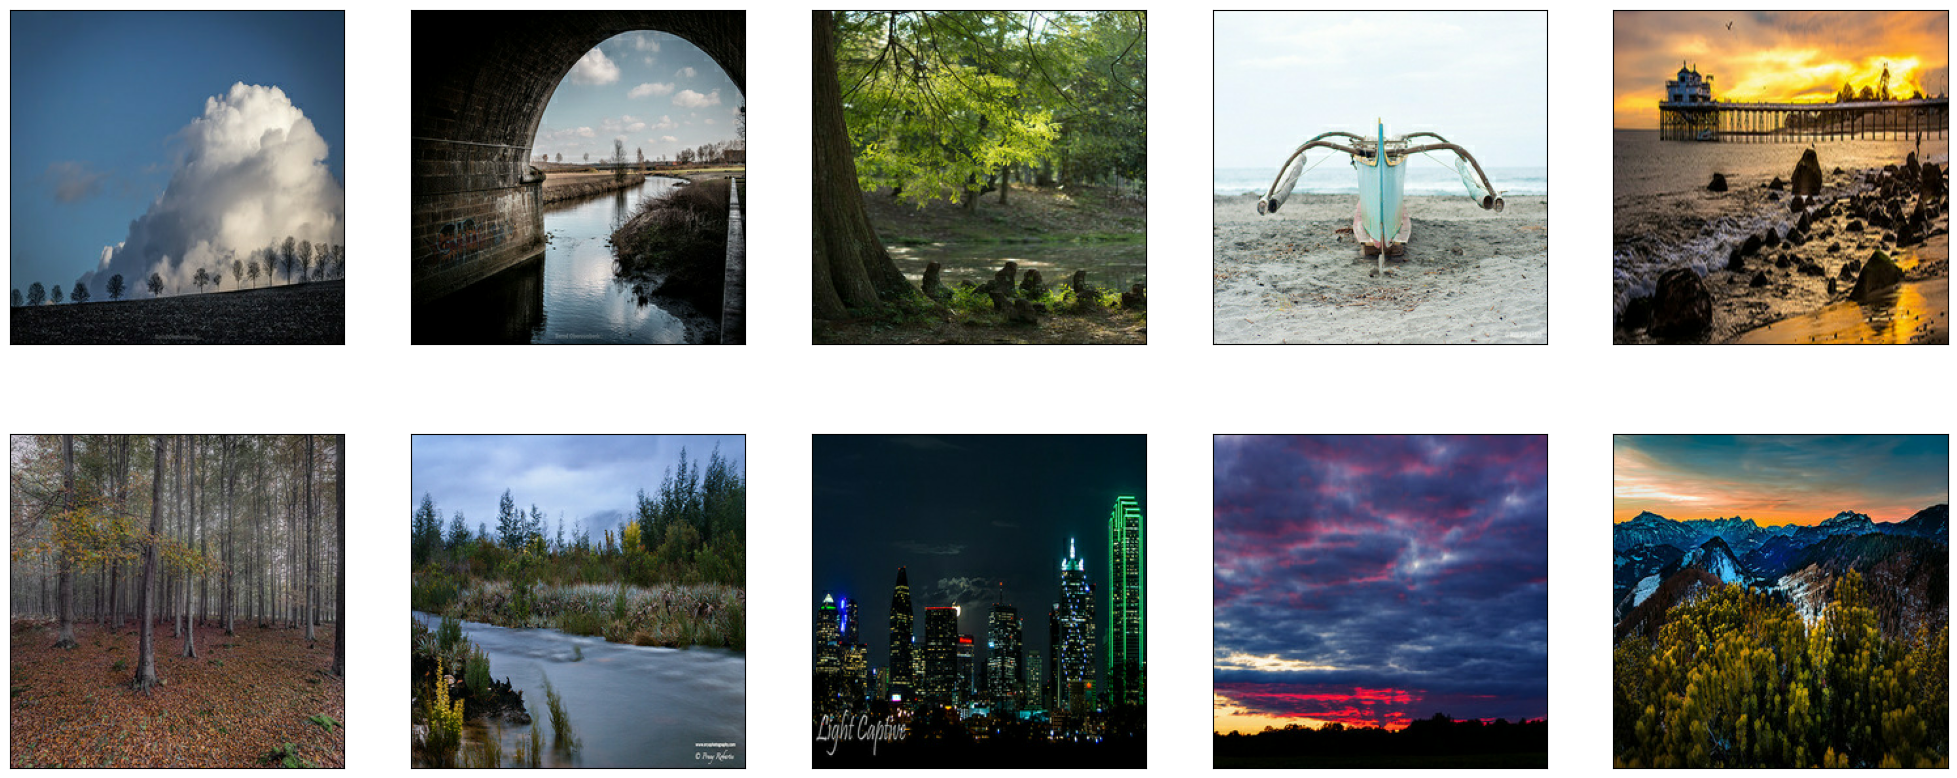

In [20]:
view_image(photo_ds,2, 5)

#### Build the generator

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

OUTPUT_CHANNELS = 3

class InstanceNormalization(layers.Layer):
    """Instance normalization layer (alternative to tfa.layers.InstanceNormalization)."""
    
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=(input_shape[-1],),
            initializer=tf.random_normal_initializer(mean=1.0, stddev=0.02),
            trainable=True)
        
        self.offset = self.add_weight(
            name='offset',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                           kernel_initializer=initializer, use_bias=False))
    
    if apply_instancenorm:
        result.add(InstanceNormalization())
    
    result.add(layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
    
    result.add(InstanceNormalization())
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())
    
    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

#### Discriminator

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class InstanceNormalization(layers.Layer):
    """Instance normalization layer (alternative to tfa.layers.InstanceNormalization)."""
    
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=(input_shape[-1],),
            initializer=tf.random_normal_initializer(mean=1.0, stddev=0.02),
            trainable=True)
        
        self.offset = self.add_weight(
            name='offset',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                           kernel_initializer=initializer, use_bias=False))
    
    if apply_instancenorm:
        result.add(InstanceNormalization())
    
    result.add(layers.LeakyReLU())
    
    return result

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)     # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)     # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                        kernel_initializer=initializer,
                        use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    norm1 = InstanceNormalization()(conv)  # Using our custom InstanceNorm
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                        kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [23]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

I0000 00:00:1753688019.632454      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


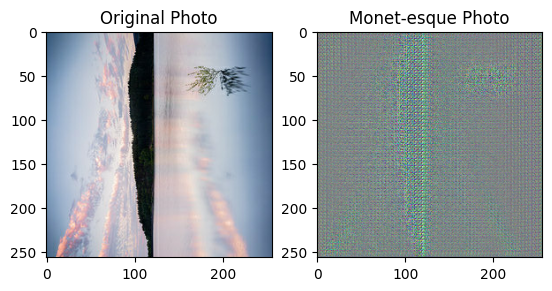

In [24]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()


### Build the Model

In [25]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

#### Loss Functions

In [26]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

In [27]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [28]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, 
        monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [29]:
cycle_gan_model.fit(
    full_dataset,
    epochs= 1, #severly limited as it simply takes too long
    steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE),
)


I0000 00:00:1753688095.565042      57 service.cc:148] XLA service 0x79e15001a5a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753688095.567645      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753688129.408653      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1759/1759 ━━━━━━━━━━━━━━━━━━━━ 638s 303ms/step - monet_disc_loss: 0.6440 - monet_gen_loss: 3.1377 - photo_disc_loss: 0.6464 - photo_gen_loss: 3.1405


### GENERATED PHOTOS

In [30]:
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
    
        plt.subplot(121)
        plt.title("Input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


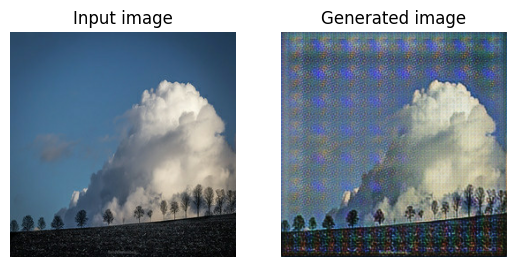

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


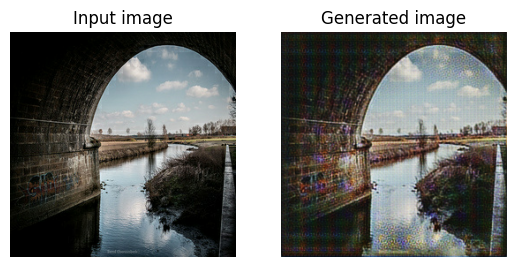

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


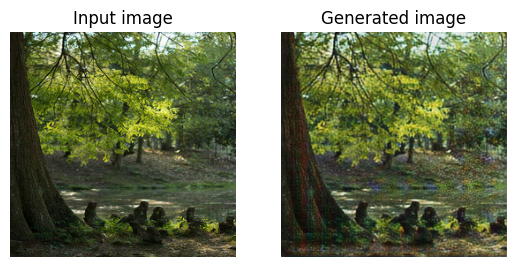

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


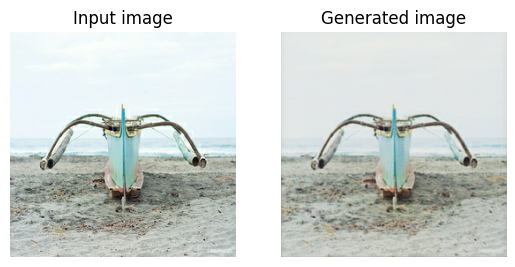

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


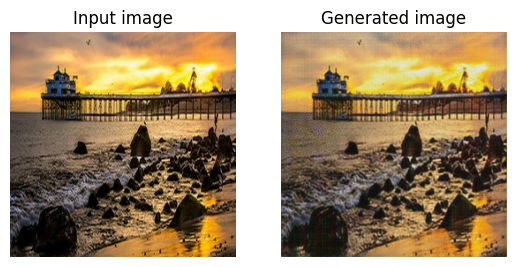

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


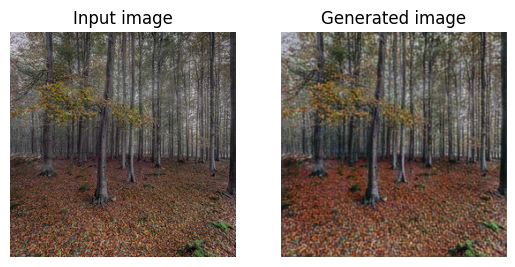

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


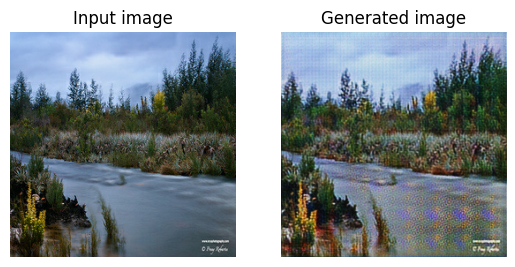

In [31]:
display_generated_samples(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, 7)


### Results and Analysis

From the EDA images and histograms as well as the final Kaggle score I get an interesting result that displays the performance of cycleGAN models.

### Conclusion

Unfortunatly I have had to stunt the performance of the model severly due to time and computatinoal constraints. But the performance was to too bad, and it was a good introduction to GAN.

### Output file

In [32]:
import PIL
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [33]:
import os
os.makedirs('../images/') # Create folder to save generated images

predict_and_save(load_dataset(PHOTO_FILENAMES).batch(1), monet_generator, '../images/')

In [34]:
import shutil
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Number of generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Number of generated samples: 7038


### Citation


Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.

https://www.kaggle.com/code/songseungwon/cyclegan-tutorial-from-scratch-monet-to-photo